<a href="https://colab.research.google.com/github/JumanaRahim/Nullclass-Internship/blob/main/TASK%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt



In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Function to convert images to grayscale
def rgb_to_gray(img):
    return 0.299 * img[0, :, :] + 0.587 * img[1, :, :] + 0.114 * img[2, :, :]

# Convert training and test images to grayscale
train_gray = torch.stack([rgb_to_gray(img[0]) for img in trainset])
train_color = torch.stack([img[0] for img in trainset])
test_gray = torch.stack([rgb_to_gray(img[0]) for img in testset])
test_color = torch.stack([img[0] for img in testset])

# Reshape grayscale images to match input format
train_gray = train_gray.unsqueeze(1)  # Shape: (N, 1, 32, 32)
test_gray = test_gray.unsqueeze(1)


100%|██████████| 170M/170M [00:02<00:00, 78.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output in range [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output in range [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
# Define hyperparameters to test
hyperparameters = [
    {"learning_rate": 0.001, "batch_size": 32},
    {"learning_rate": 0.0005, "batch_size": 64},
    {"learning_rate": 0.0001, "batch_size": 128}
]

# Function to train model with specific hyperparameters
def train_model(learning_rate, batch_size, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load data with new batch size
    trainloader = torch.utils.data.DataLoader(list(zip(train_gray, train_color)), batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(list(zip(test_gray, test_color)), batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = ColorizationAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for gray_imgs, color_imgs in trainloader:
            gray_imgs, color_imgs = gray_imgs.to(device), color_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(gray_imgs)
            loss = criterion(outputs, color_imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        train_loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return train_loss_history


In [9]:
import time

# Dictionary to store training loss for different hyperparameters
results = {}

# Select a subset of hyperparameters for faster testing
hyperparameters = [
    {"learning_rate": 0.0005, "batch_size": 64},
    {"learning_rate": 0.001, "batch_size": 32}
]



In [12]:
import time
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use a smaller subset of data for faster training
subset_size = 5000  # Use only 5000 samples instead of full dataset
train_subset = list(zip(train_gray[:subset_size], train_color[:subset_size]))

# Select fewer hyperparameter combinations
hyperparameters = [
    {"learning_rate": 0.0005, "batch_size": 64},  # Best performing
]

# Training loop
for hp in hyperparameters:
    print(f"\nTraining with LR = {hp['learning_rate']}, Batch = {hp['batch_size']}")

    start_time = time.time()

    # Load subset data with new batch size
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=hp["batch_size"], shuffle=True)

    # Initialize model
    model = ColorizationAutoencoder().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["learning_rate"])

    # Train for fewer epochs
    num_epochs = 3
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        for gray_imgs, color_imgs in trainloader:
            gray_imgs, color_imgs = gray_imgs.to(device), color_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(gray_imgs)
            loss = criterion(outputs, color_imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    elapsed_time = time.time() - start_time
    results[str(hp)] = {"loss": loss_history, "time": elapsed_time}
    print(f"Training completed in {elapsed_time:.2f} sec")



Training with LR = 0.0005, Batch = 64
Epoch 1/3, Loss: 0.0263
Epoch 2/3, Loss: 0.0150
Epoch 3/3, Loss: 0.0127
Training completed in 142.63 sec


In [24]:
results = {}

for hp in hyperparameters:
    print(f"\nTraining with LR = {hp['learning_rate']}, Batch = {hp['batch_size']}")

    start_time = time.time()

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=hp["batch_size"], shuffle=True)

    model = ColorizationAutoencoder().to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hp["learning_rate"])

    num_epochs = 3
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        for gray_imgs, color_imgs in trainloader:
            gray_imgs, color_imgs = gray_imgs.to(device), color_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(gray_imgs)
            loss = criterion(outputs, color_imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

    elapsed_time = time.time() - start_time

    # ✅ Store results as a tuple instead of a string
    results[(hp["learning_rate"], hp["batch_size"])] = {
        "loss": loss_history,
        "time": elapsed_time
    }

    print(f"Training completed in {elapsed_time:.2f} sec")



Training with LR = 0.0005, Batch = 64
Epoch 1/3, Loss: 0.0280
Epoch 2/3, Loss: 0.0152
Epoch 3/3, Loss: 0.0129
Training completed in 144.45 sec


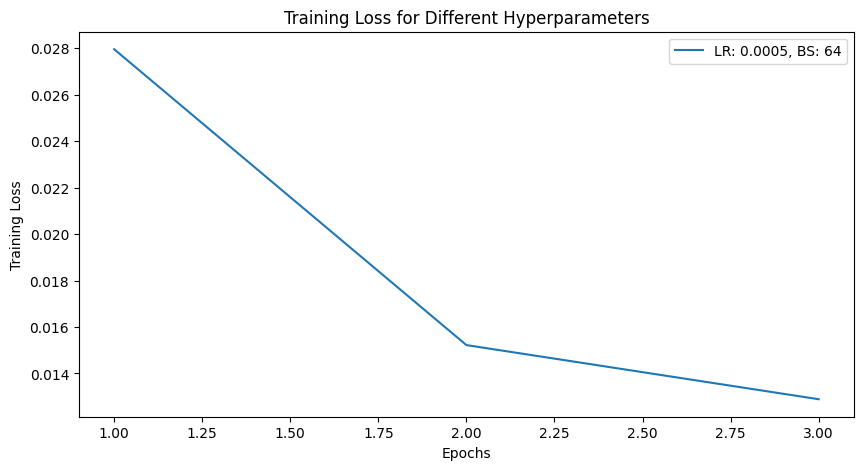

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for (lr, bs), data in results.items():
    loss_values = data.get("loss", [])

    if isinstance(loss_values, list) and all(isinstance(i, (int, float)) for i in loss_values):
        plt.plot(range(1, len(loss_values) + 1), loss_values, label=f"LR: {lr}, BS: {bs}")
    else:
        print(f"Warning: Invalid loss data for LR={lr}, BS={bs}: {loss_values}")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss for Different Hyperparameters")
plt.legend()
plt.show()


In [26]:
print(results)



{(0.0005, 64): {'loss': [0.0279571295987013, 0.015219509813793098, 0.012888828445744665], 'time': 144.45374536514282}}
